# My Identity

**Nama:** NAFIATUL FADLILAH <br>


# Business Understanding

**Studi kasus:** Klasifikasi gambar rontgen paru-paru <br>
**Tujuan:** Membuat model yang dapat melakukan klasifikasi terhadap data gambar rontgen paru-paru dengan mengkategorikannya ke *class* normal dan *class* covid. <br>


# Data Understanding

**Data Sample:**
*  `Data Train`: menggunakan 300 data dimana diambil sampel sebanyak 150 data dari 1.626 data gambar rontgen paru-paru pasien terpapar covid dan 150 lainnya diambil dari 1.802 data gambar rontgen paru-paru normal. Pengambilan sampel *data train* dengan mengambil data gambar pada urutan ganjil. <br>
* `Data Test`: terdiri dari 100 data yang tidak digunakan dalam proses *training*, dimana 50 data merupakan gambar rontgen paru-paru terpapar covid dan 50 lainnya gambar rontgen paru-paru normal. Pengambilan sampel *data test* dengan mengambil data gambar pada urutan genap.

Pembagian *class* yang seimbang dilakukan untuk mencegah bias dalam model. Karena jika satu *class* dominan dibandingkan dengan *class* lainnya, model mungkin akan cenderung memprediksi kelas dominan tersebut, yang bisa mengakibatkan performa yang buruk pada kelas minoritas saat model diterapkan pada data baru.

# Data Preparation

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import os

## Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/DL_Data/dataset/'

image dimensions:  (256, 256)


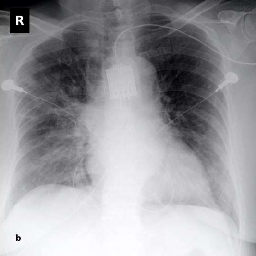

In [ ]:
# mengecek sampel gambar paru-paru terkena covid dari data train
from PIL import Image

covid_image_path = path + 'train/COVID/COVID_7.png'
covid_image = Image.open(covid_image_path)
print('image dimensions: ', covid_image.size)
covid_image

image dimensions:  (232, 232)


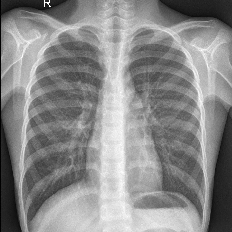

In [ ]:
# mengecek sampel gambar paru-paru normal dari data train
normal_image_path = path + 'train/NORMAL/NORMAL_7.png'
normal_image = Image.open(normal_image_path)
print('image dimensions: ', normal_image.size)
normal_image

In [ ]:
# definisikan path data train dan test
train_dir = path + 'train'
test_dir = path + 'test'

In [ ]:
# melihat variasi mode dan dimensi gambar
from itertools import chain
from matplotlib import pyplot as plt

unique_dimensions = set()
unique_modes = set()

for subdir in chain(os.listdir(train_dir), os.listdir(test_dir)):
  subdir_path = os.path.join(train_dir, subdir)
  for filename in os.listdir(subdir_path):
    file_path = os.path.join(subdir_path, filename)
    image = Image.open(file_path)
    unique_dimensions.add(image.size[0])
    unique_dimensions.add(image.size[1])
    unique_modes.add(image.mode)

print('unique modes: ', unique_modes)
print('unique dimensions: ', unique_dimensions)

unique modes:  {'RGB', 'RGBA'}
unique dimensions:  {256, 232}


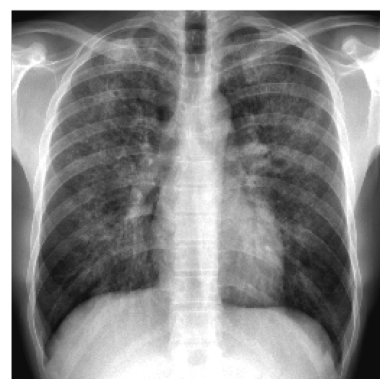

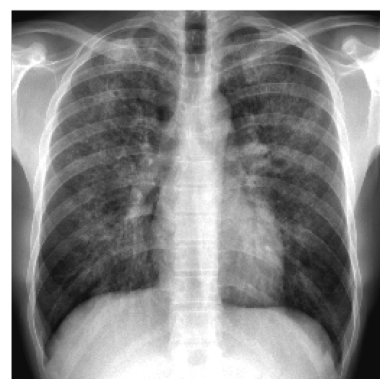

In [ ]:
# mengecek gambar dengan mode == 'RGBA'
for subdir in chain(os.listdir(train_dir), os.listdir(test_dir)):
  subdir_path = os.path.join(train_dir, subdir)
  for filename in os.listdir(subdir_path):
    file_path = os.path.join(subdir_path, filename)
    image = Image.open(file_path)

    if image.mode == 'RGBA':
      plt.axis('off')
      plt.imshow(image)
      plt.show()

## Creating Image Generator Pipeline

### Data Augmentation

**Data augmentation** pada *preprocessing* ini dilakukan untuk meningkatkan atau memperkaya variasi dataset sehingga dapat mencegah *overfitting* pada model. Data augmentation ini menggunakan *tools* `ImageDataGenerator` di `Keras` untuk membuat modifikasi kecil pada gambar seperti **rotasi**, **rescaling**, hingga **flipping** agar tercipta gambar baru yang mirip gambar aslinya.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # brightness_range = (0.8, 1.2),
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
DIMENSIONS = [224, 224]

Menggunakan **pipeline data generator** dalam *modelling* untuk mengotomatisasi dan mempermudah proses penyediaan data ke model selama *training*. Pipeline sebagai *interface* yang efisien antara dataset gambar dengan model *neural network* sehingga akan **mempermudah suplai data ke model secara berkelanjutan melalui batch**.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = tuple(DIMENSIONS),
    class_mode = 'binary'
)

valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size = tuple(DIMENSIONS),
    class_mode = 'binary'
)

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Modelling

## Creating CNN Model

### CNN Architecture - DenseNet201

Arsitektur **DenseNet201** pada CNN sering diimplementasikan dalam kasus klasifikasi data gambar medis karena beberapa alasan berikut:
*  **Koneksi Padat**: memungkinkan *network* memanfaatkan pengetahuan kolektif dari semua *layer* sebelumnya sehingga bermanfaat dalam identifikasi pola kompleks dalam gambar rontgen. <br>
*  **Efisiensi Parameter**: lebih efisien dari segi komputasi dan memori. Hal ini penting karena data rontgen yang digunakan memiliki ukuran besar. <br>
*  **Mencegah Overfitting**: dengan menerima input dari semua *layer* sebelumnya sehingga dapat membantu mengurangi *overfitting* yang menjadi masalah umum *modelling* menggunakan data spesifik seperti gambar rontgen.
*  **Pemeliharaan Gradien**: DenseNet memudahkan aliran gradien selama proses *backpropagation* karena tidak ada *layer* yang terisolasi sehingga *training* menjadi lebih stabil.
*  **Menggunakan Fitur Tingkat Tinggi**: DenseNet efektif dalam menggunakan fitur tingkat rendah dan tinggi yang mampu meningkatkan kemampuan model dalam klasifikasi yang menunjukkan adanya kondisi medis tertentu.

In [ ]:
import keras
import tensorflow
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Memuat model EfficientNetB0 dengan bobot yang telah dilatih pada ImageNet
# base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Menambahkan lapisan baru untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Menggabungkan model dasar dan lapisan baru
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan lapisan model dasar
for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 [==============================] - 1s 0us/step


## Compailing and Training the Model

In [ ]:
from tensorflow.keras.optimizers import Adam

BATCH_SIZE = 50
EPOCHS = 10

model.compile(loss= 'binary_crossentropy',
              optimizer= Adam(learning_rate = 0.0001),
              metrics= ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1
)

Epoch 1/10
10/10 [==============================] - 159s 14s/step - loss: 1.1240 - accuracy: 0.4967 - val_loss: 0.9538 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 132s 13s/step - loss: 0.9784 - accuracy: 0.4767 - val_loss: 0.8591 - val_accuracy: 0.4800
Epoch 3/10
10/10 [==============================] - 141s 14s/step - loss: 0.8881 - accuracy: 0.4300 - val_loss: 0.7929 - val_accuracy: 0.4300
Epoch 4/10
10/10 [==============================] - 132s 14s/step - loss: 0.8282 - accuracy: 0.3967 - val_loss: 0.7465 - val_accuracy: 0.4700
Epoch 5/10
10/10 [==============================] - 130s 13s/step - loss: 0.7966 - accuracy: 0.3767 - val_loss: 0.7119 - val_accuracy: 0.5400
Epoch 6/10
10/10 [==============================] - 133s 14s/step - loss: 0.7427 - accuracy: 0.4600 - val_loss: 0.6821 - val_accuracy: 0.5700
Epoch 7/10
10/10 [==============================] - 129s 13s/step - loss: 0.7317 - accuracy: 0.4467 - val_loss: 0.6543 - val_accuracy: 0.6000
Epoch 

In [ ]:
# save model dengan hasil terbaik
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

# Model Evaluation

## Plotting Learning Curves

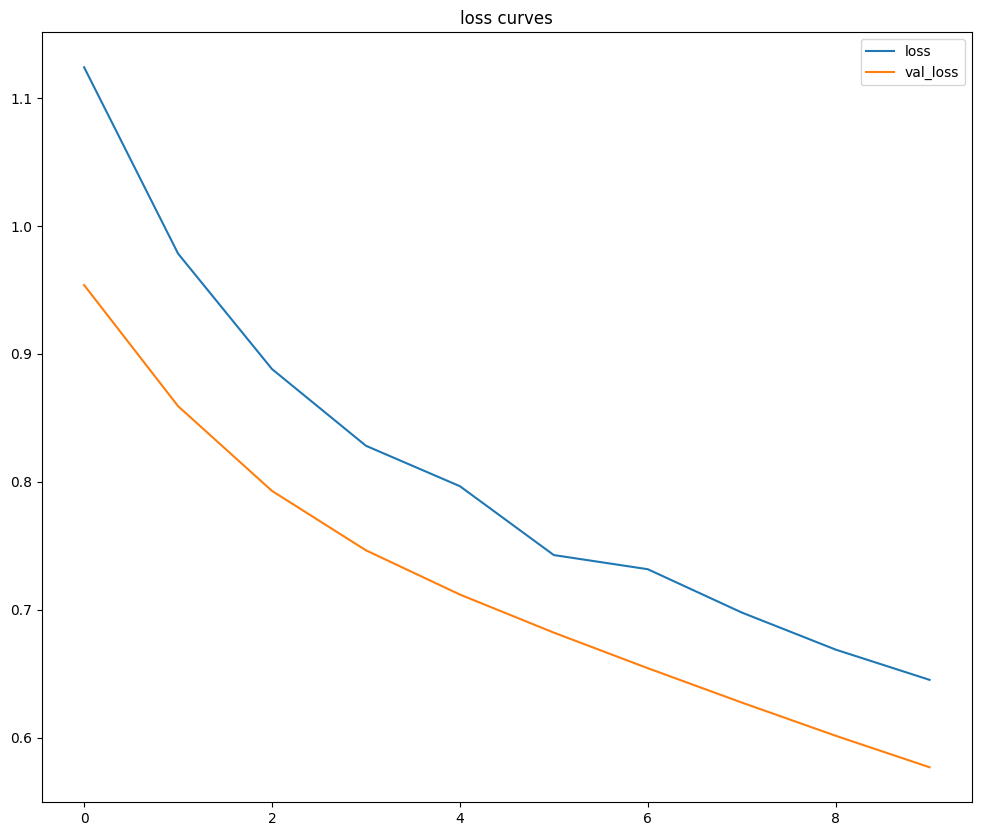

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 10))
plt.title('loss curves')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

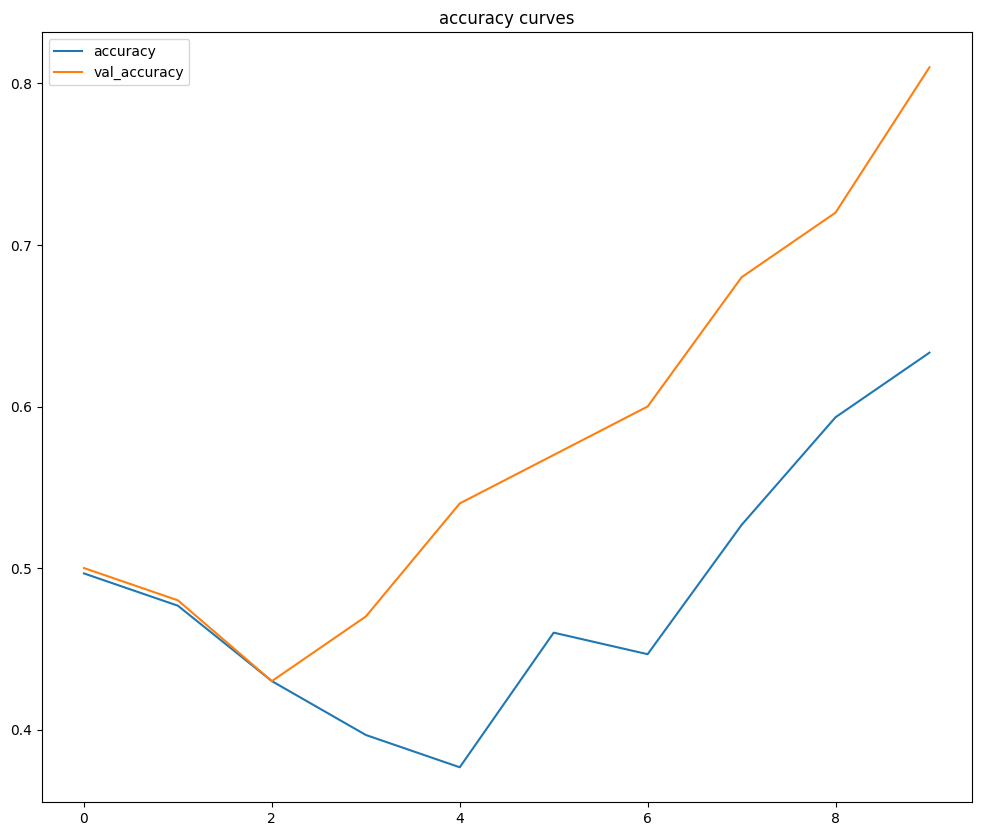

In [ ]:
plt.figure(figsize= (12, 10))
plt.title('accuracy curves')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

## Displaying Confusion Matrix

In [ ]:
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size = (DIMENSIONS),
    class_mode = 'binary',
    shuffle = False
)

y_pred = model.predict(test_generator)
y_readable_a = np.round(y_pred, 4)
print(y_readable_a[:10])

Found 100 images belonging to 2 classes.
4/4 [==============================] - 39s 7s/step
[[0.375 ]
 [0.4935]
 [0.4448]
 [0.6104]
 [0.4011]
 [0.4316]
 [0.3781]
 [0.3774]
 [0.6303]
 [0.5324]]


In [ ]:
y_readable_b = np.round(y_pred, 4)
print(y_readable_b[-10:])

[[0.6493]
 [0.5962]
 [0.7155]
 [0.6036]
 [0.4815]
 [0.6671]
 [0.4387]
 [0.6675]
 [0.5444]
 [0.4777]]


Text(89.74999999999999, 0.5, 'Actual')

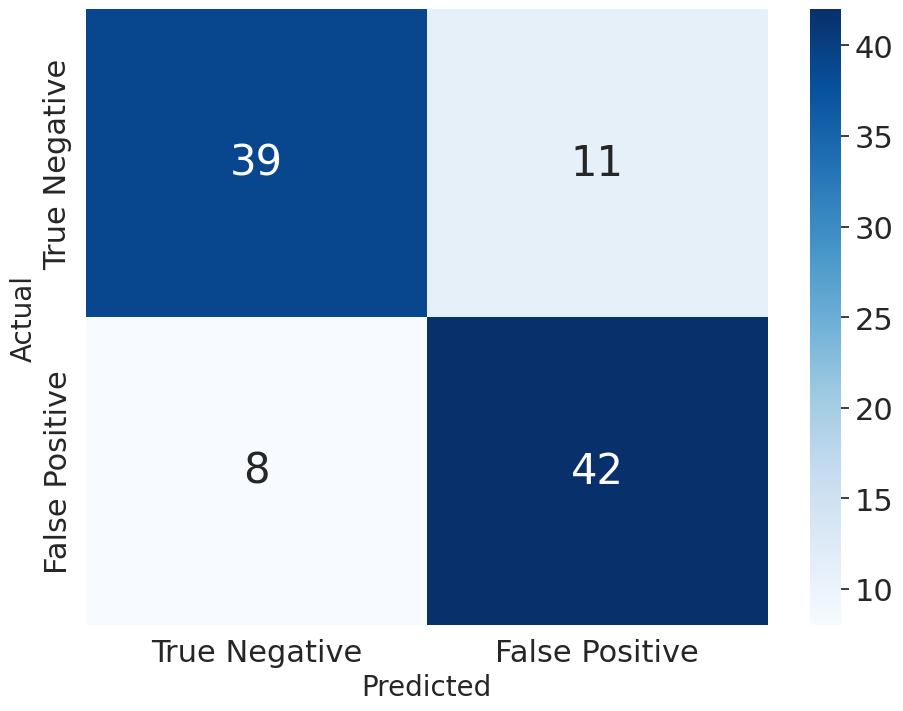

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = test_generator.labels

y_pred = np.round(y_pred)

confusion_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
from seaborn import heatmap

plt.figure(figsize= (11, 8))
sns.set(font_scale = 2)

heatmap(confusion_matrix,
        annot=True, # print nilai" dalam sel
        annot_kws={"size": 30}, # set ukuran nilai dalam sel
        fmt='g', # format angka dalam notasi umum
        cmap='Blues', # skema warna yg dipake
        xticklabels=['True Negative', 'False Positive'], # label sumbu x
        yticklabels=['True Negative', 'False Positive']) # label sumbu y

plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)

*Confusion matrix* di atas menunjukkan bahwa model sudah cukup baik dalam melakukan klasifikasi data gambar. Hal ini karena pada bagian diagonal sudah memiliki nilai yang tinggi yakni 39 dan 42. Sedangkan *error* yang dilakukan model dalam mengklasifikasikan gambar sejumlah 19 kesalahan.

## Displaying those images that were wrongly classified

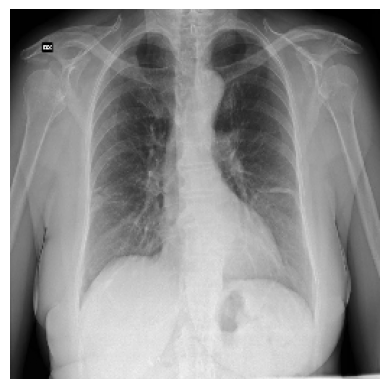

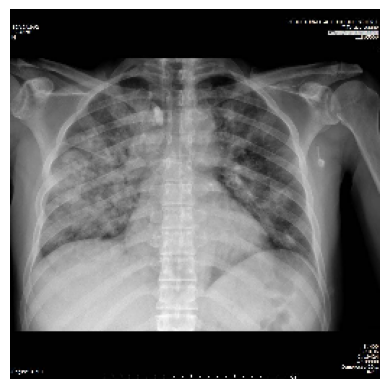

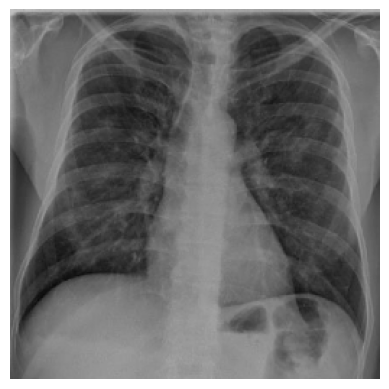

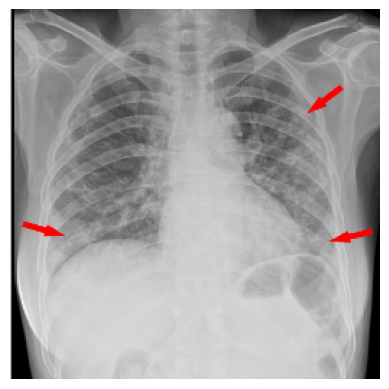

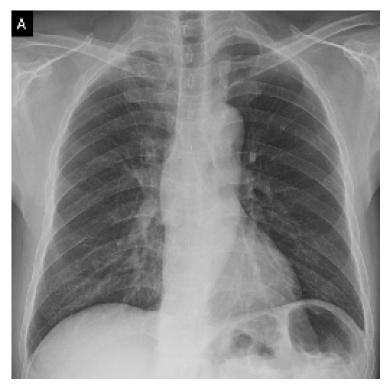

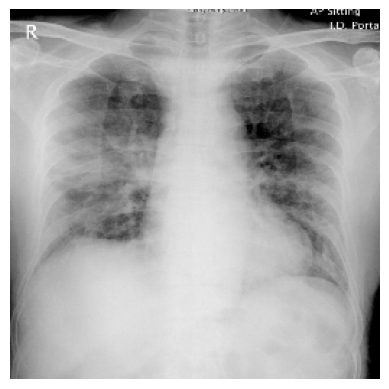

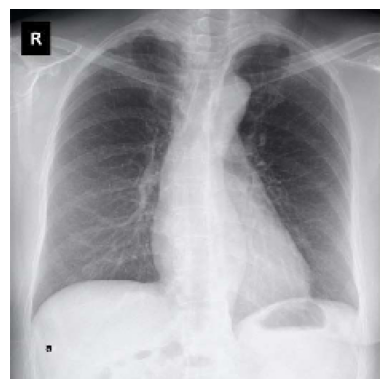

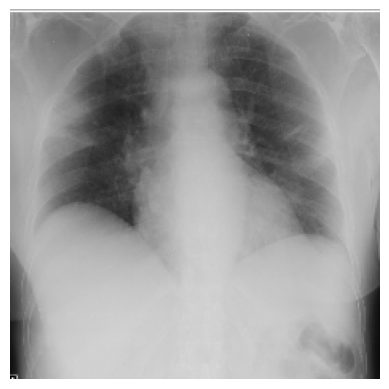

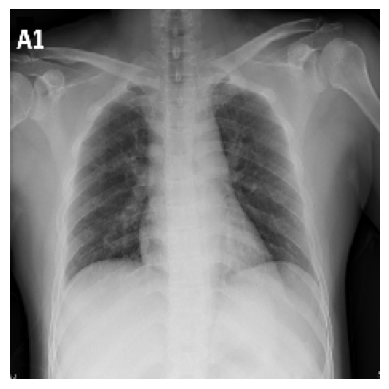

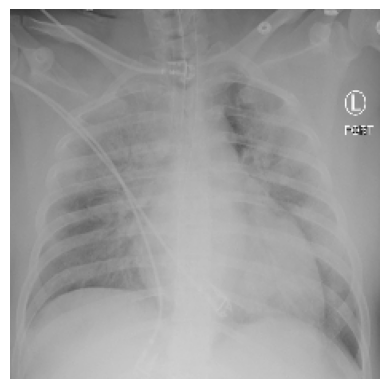

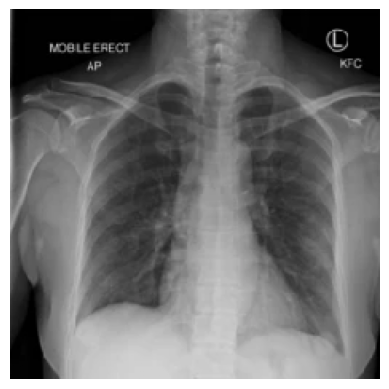

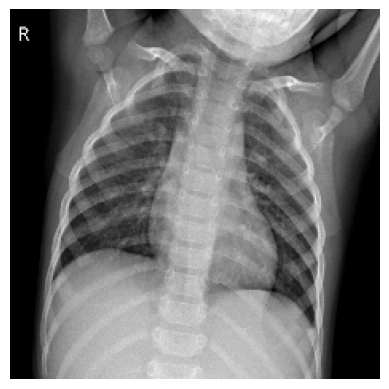

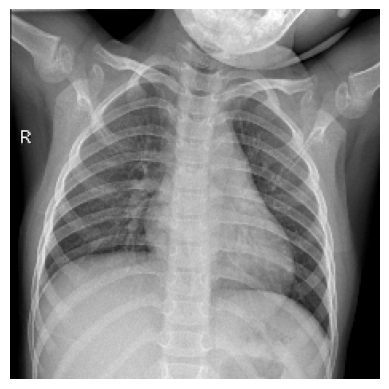

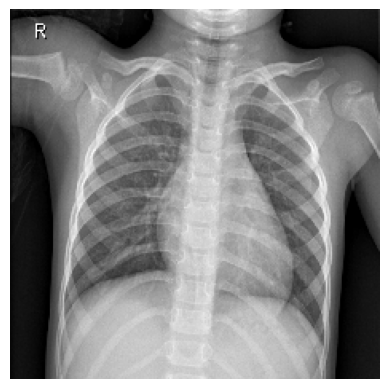

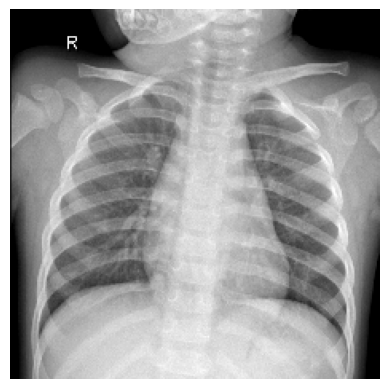

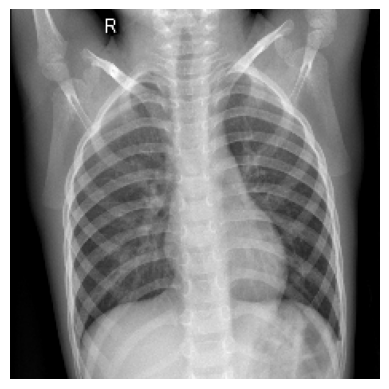

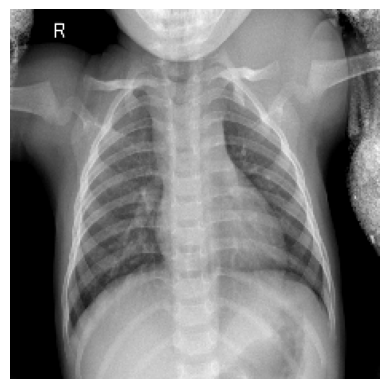

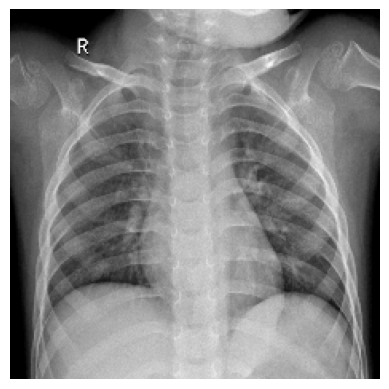

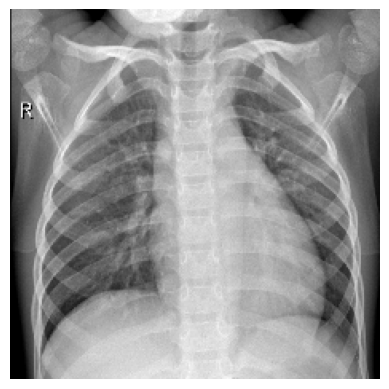

In [ ]:
# mengecek gambar yang salah diklasifikasi
misclassified_indices = np.where(y_true.reshape(-1, 1) != y_pred)[0]

for i in misclassified_indices:
  image_path = test_generator.filepaths[i]
  image = plt.imread(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Hitung metrik klasifikasi
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Tampilkan metrik
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-Score: {f1}')

Accuracy: 0.81
Recall: 0.81
Precision: 0.8111200321156162
F1-Score: 0.8098288459613652


Berdasarkan metrik hasil evaluasi model tersebut, berikut penjelasan performa model klasifikasi gambar rontgen paru-paru:

- **Accuracy (Akurasi)**: Akurasi model sebesar **0.81** atau **81%** bermakna model berhasil memprediksi label yang benar untuk **81%** dari keseluruhan data yang diuji. Ini menjadi indikator yang baik bahwa model cukup akurat dalam klasifikasi.

- **Recall (Sensitivitas)**: Dengan nilai recall juga sebesar **0.81** atau **81%**, ini menunjukkan bahwa model mampu mengidentifikasi **81%** dari semua kasus positif yang sebenarnya. Dalam konteks klasifikasi gambar medis, seperti rontgen, ini menjadi penting karena menunjukkan kemampuan model untuk menangkap sebagian besar kasus yang relevan.

- **Precision (Presisi)**: Presisi model sebesar **0.8111** atau **81.11%**, yang menunjukkan bahwa dari semua prediksi positif yang dibuat oleh model, **81.11%** dari prediksi tersebut adalah benar. Nilai presisi yang tinggi menunjukkan bahwa model tidak banyak membuat kesalahan tipe I (*false positives*).

- **F1-Score**: Skor F1 adalah **0.8098** atau **80.98%**, yang merupakan rata-rata harmonik dari presisi dan *recall*. Skor F1 yang tinggi menunjukkan bahwa model memiliki keseimbangan yang baik antara presisi dan recall, yang sangat penting dalam banyak aplikasi praktis di mana kedua aspek tersebut sama pentingnya.

Secara keseluruhan, **model yang dibuat menggunakan arsitekur CNN  DenseNet201** sudah menunjukkan performa yang solid dengan nilai-nilai yang konsisten di atas **80%** untuk semua metrik utama. Ini menunjukkan bahwa model **sudah cukup andal dalam klasifikasi gambar rontgen** yang diberikan.